# Assignment 6

In this assignment, you will learn about kernel methods.

1. Download the Breast Cancer Wisconsin dataset https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data and perform all the necessary data pre-processing.
2. Use the Scikit-learn implementation of SVM (the SVC() function) to predict if the tumor is malignant or not. Try different kernels.
3. Test your models.
4. Implement kernel regression to model the data from Uˇ
5. Plot the data and your predictions.


In [1]:
# Import all dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    r2_score,
    make_scorer,
)

### Data Retrieval


In [2]:
# Load the breast cancer data into a pandas dataframe
data = pd.read_csv("./data/data.csv")
data

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M        17.99         10.38          122.80     1001.0   
1      842517         M        20.57         17.77          132.90     1326.0   
2    84300903         M        19.69         21.25          130.00     1203.0   
3    84348301         M        11.42         20.38           77.58      386.1   
4    84358402         M        20.29         14.34          135.10     1297.0   
..        ...       ...          ...           ...             ...        ...   
564    926424         M        21.56         22.39          142.00     1479.0   
565    926682         M        20.13         28.25          131.20     1261.0   
566    926954         M        16.60         28.08          108.30      858.1   
567    927241         M        20.60         29.33          140.10     1265.0   
568     92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0            0.11840           0.27760         0.30010              0.14710   
1            0.08474           0.07864         0.08690              0.07017   
2            0.10960           0.15990         0.19740              0.12790   
3            0.14250           0.28390         0.24140              0.10520   
4            0.10030           0.13280         0.19800              0.10430   
..               ...               ...             ...                  ...   
564          0.11100           0.11590         0.24390              0.13890   
565          0.09780           0.10340         0.14400              0.09791   
566          0.08455           0.10230         0.09251              0.05302   
567          0.11780           0.27700         0.35140              0.15200   
568          0.05263           0.04362         0.00000              0.00000   

     ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0    ...          17.33           184.60      2019.0           0.16220   
1    ...          23.41           158.80      1956.0           0.12380   
2    ...          25.53           152.50      1709.0           0.14440   
3    ...          26.50            98.87       567.7           0.20980   
4    ...          16.67           152.20      1575.0           0.13740   
..   ...            ...              ...         ...               ...   
564  ...          26.40           166.10      2027.0           0.14100   
565  ...          38.25           155.00      1731.0           0.11660   
566  ...          34.12           126.70      1124.0           0.11390   
567  ...          39.42           184.60      1821.0           0.16500   
568  ...          30.37            59.16       268.6           0.08996   

     compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0              0.66560           0.7119                0.2654          0.4601   
1              0.18660           0.2416                0.1860          0.2750   
2              0.42450           0.4504                0.2430          0.3613   
3              0.86630           0.6869                0.2575          0.6638   
4              0.20500           0.4000                0.1625          0.2364   
..                 ...              ...                   ...             ...   
564            0.21130           0.4107                0.2216          0.2060   
565            0.19220           0.3215                0.1628          0.2572   
566            0.30940           0.3403                0.1418          0.2218   
567            0.86810           0.9387                0.2650          0.4087   
568            0.06444           0.0000                0.0000          0.2871   

     fractal_dimension_worst  Unnamed: 32  
0                    0.11890          NaN  
1                    0.08902          NaN  
2                    0.08758          NaN  
3                    0.17300          NaN  
4      

### Data Preprocessing


In [3]:
# Drop the Unnamed: 32 column
data.drop(["Unnamed: 32"], axis=1, inplace=True)

# Drop the id column (we don't need it)
data.drop(["id"], axis=1, inplace=True)

# Swap the order of the columns so that the target variable is the last column
columns = list(data.columns.values)
columns.pop(columns.index("diagnosis"))
data = data[columns + ["diagnosis"]]

# Convert the categorical variable into a numerical variable
data["diagnosis"] = data["diagnosis"].astype("category").cat.codes

# Divide data into three categories: mean, se, worst
features_mean = data.columns[:10]
features_se = data.columns[10:20]
features_worst = data.columns[20:30]

data

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0             0.27760         0.30010              0.14710         0.2419   
1             0.07864         0.08690              0.07017         0.1812   
2             0.15990         0.19740              0.12790         0.2069   
3             0.28390         0.24140              0.10520         0.2597   
4             0.13280         0.19800              0.10430         0.1809   
..                ...             ...                  ...            ...   
564           0.11590         0.24390              0.13890         0.1726   
565           0.10340         0.14400              0.09791         0.1752   
566           0.10230         0.09251              0.05302         0.1590   
567           0.27700         0.35140              0.15200         0.2397   
568           0.04362         0.00000              0.00000         0.1587   

     fractal_dimension_mean  ...  texture_worst  perimeter_worst  area_worst  \
0                   0.07871  ...          17.33           184.60      2019.0   
1                   0.05667  ...          23.41           158.80      1956.0   
2                   0.05999  ...          25.53           152.50      1709.0   
3                   0.09744  ...          26.50            98.87       567.7   
4                   0.05883  ...          16.67           152.20      1575.0   
..                      ...  ...            ...              ...         ...   
564                 0.05623  ...          26.40           166.10      2027.0   
565                 0.05533  ...          38.25           155.00      1731.0   
566                 0.05648  ...          34.12           126.70      1124.0   
567                 0.07016  ...          39.42           184.60      1821.0   
568                 0.05884  ...          30.37            59.16       268.6   

     smoothness_worst  compactness_worst  concavity_worst  \
0             0.16220            0.66560           0.7119   
1             0.12380            0.18660           0.2416   
2             0.14440            0.42450           0.4504   
3             0.20980            0.86630           0.6869   
4             0.13740            0.20500           0.4000   
..                ...                ...              ...   
564           0.14100            0.21130           0.4107   
565           0.11660            0.19220           0.3215   
566           0.11390            0.30940           0.3403   
567           0.16500            0.86810           0.9387   
568           0.08996            0.06444           0.0000   

     concave points_worst  symmetry_worst  fractal_dimension_worst  diagnosis  
0                  0.2654          0.4601                  0.11890          1  
1                  0.1860          0.2750                  0.08902          1  
2                  0.2430          0.3613                  0.08758          1  
3                  0.2575          0.6638                  0.17300          1  
4                  0.1625          0.2364        

### Data Analyzing


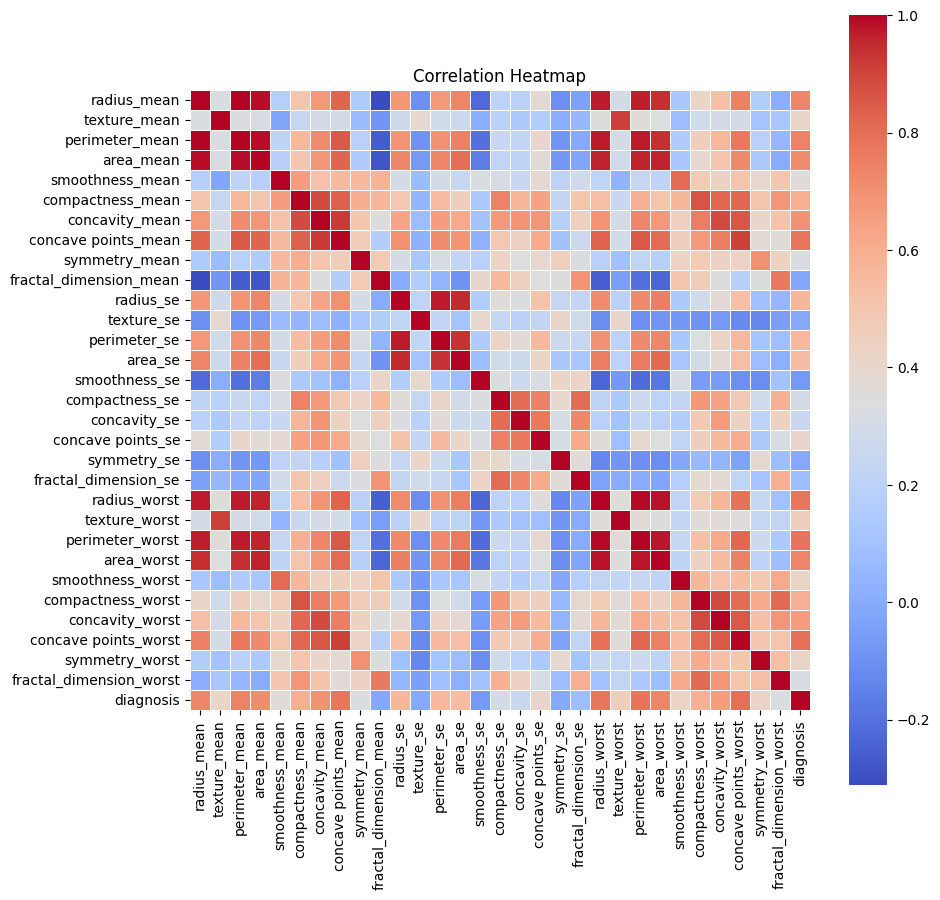

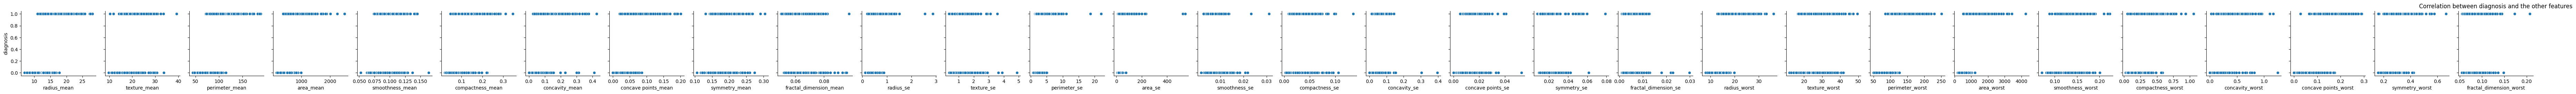

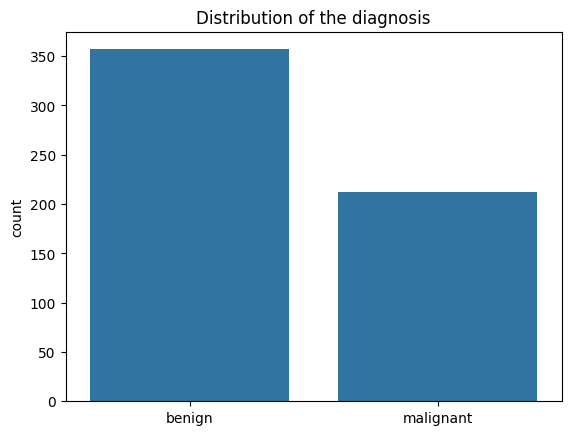

In [4]:
# Exploratory Data Analysis (EDA)
correlation_matrix = data.corr()

_, axis = plt.subplots(1, figsize=(10, 10))
sns.heatmap(
    correlation_matrix,
    square=True,
    cmap="coolwarm",
    linewidths=0.5,
    ax=axis,
)
plt.title("Correlation Heatmap")
plt.show()

# Plot the correlation between the diagnosis and the other features
sns.pairplot(
    data,
    x_vars=data.columns[:-1],
    y_vars=data.columns[-1],
)
plt.title("Correlation between diagnosis and the other features")
plt.show()

# Plot the distribution of the diagnosis
sns.countplot(x="diagnosis", data=data)
plt.title("Distribution of the diagnosis")
plt.xticks(ticks=[0, 1], labels=["benign", "malignant"])
plt.xlabel(None)
plt.show()

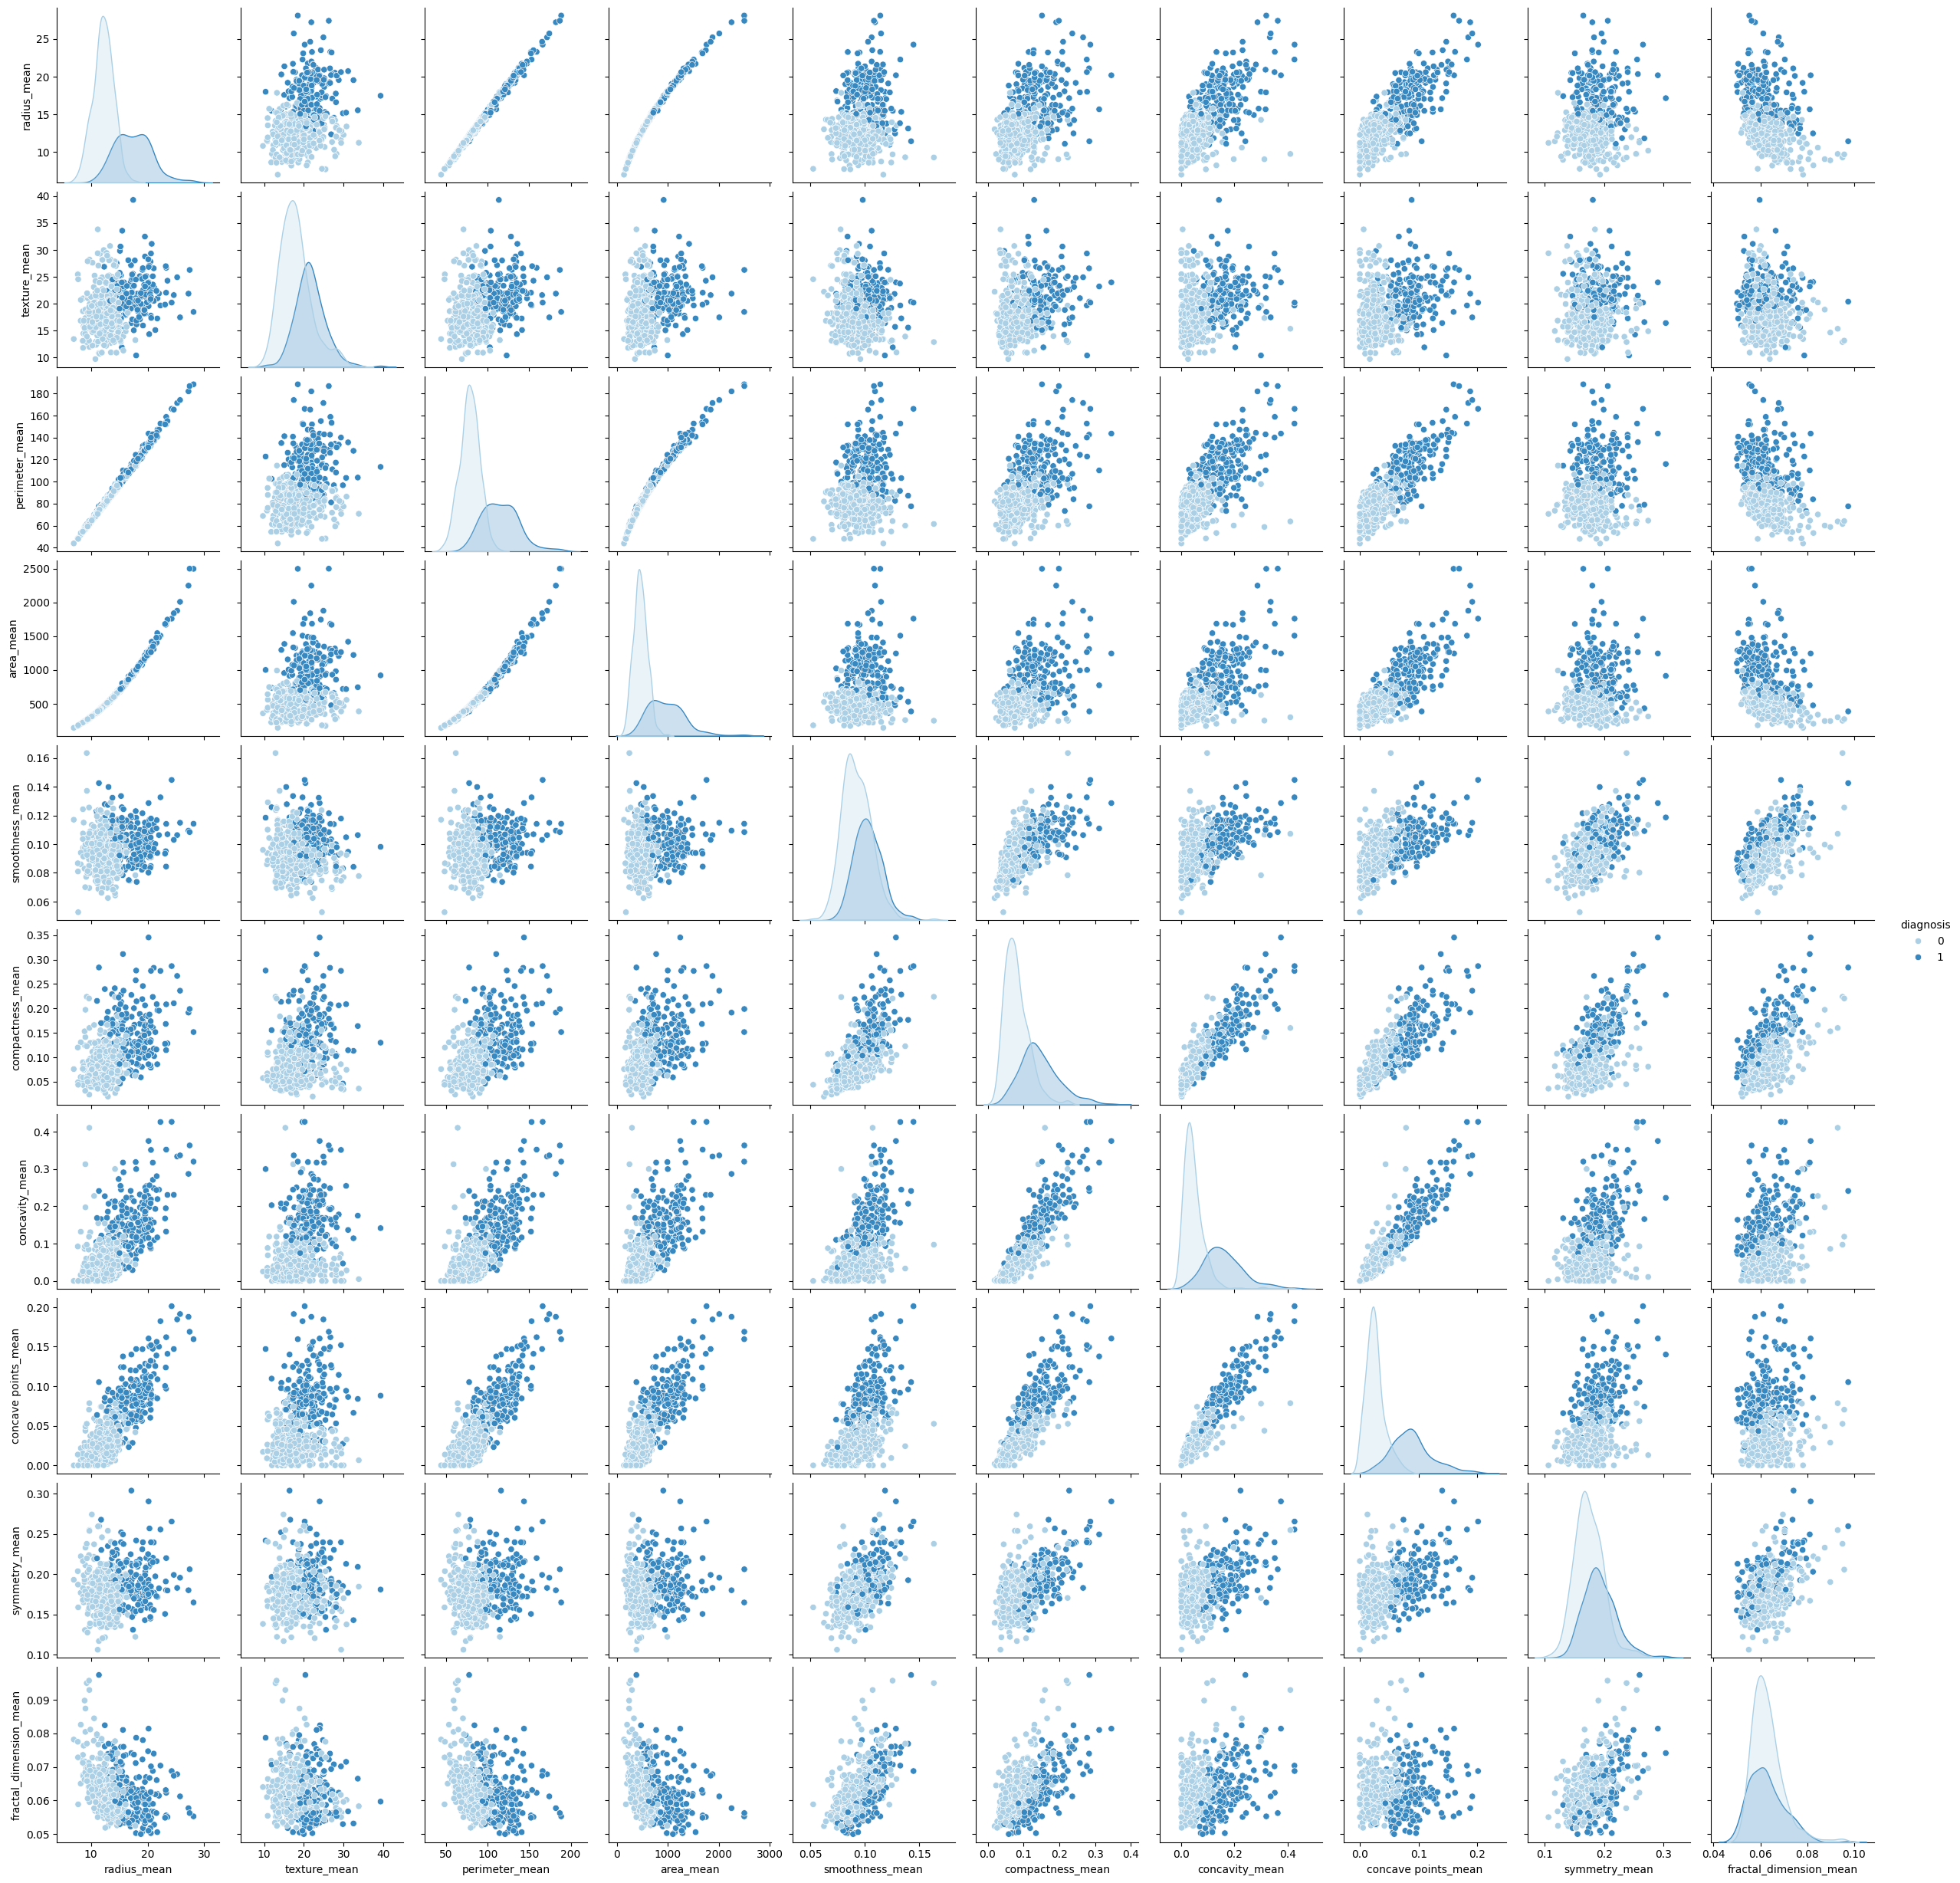

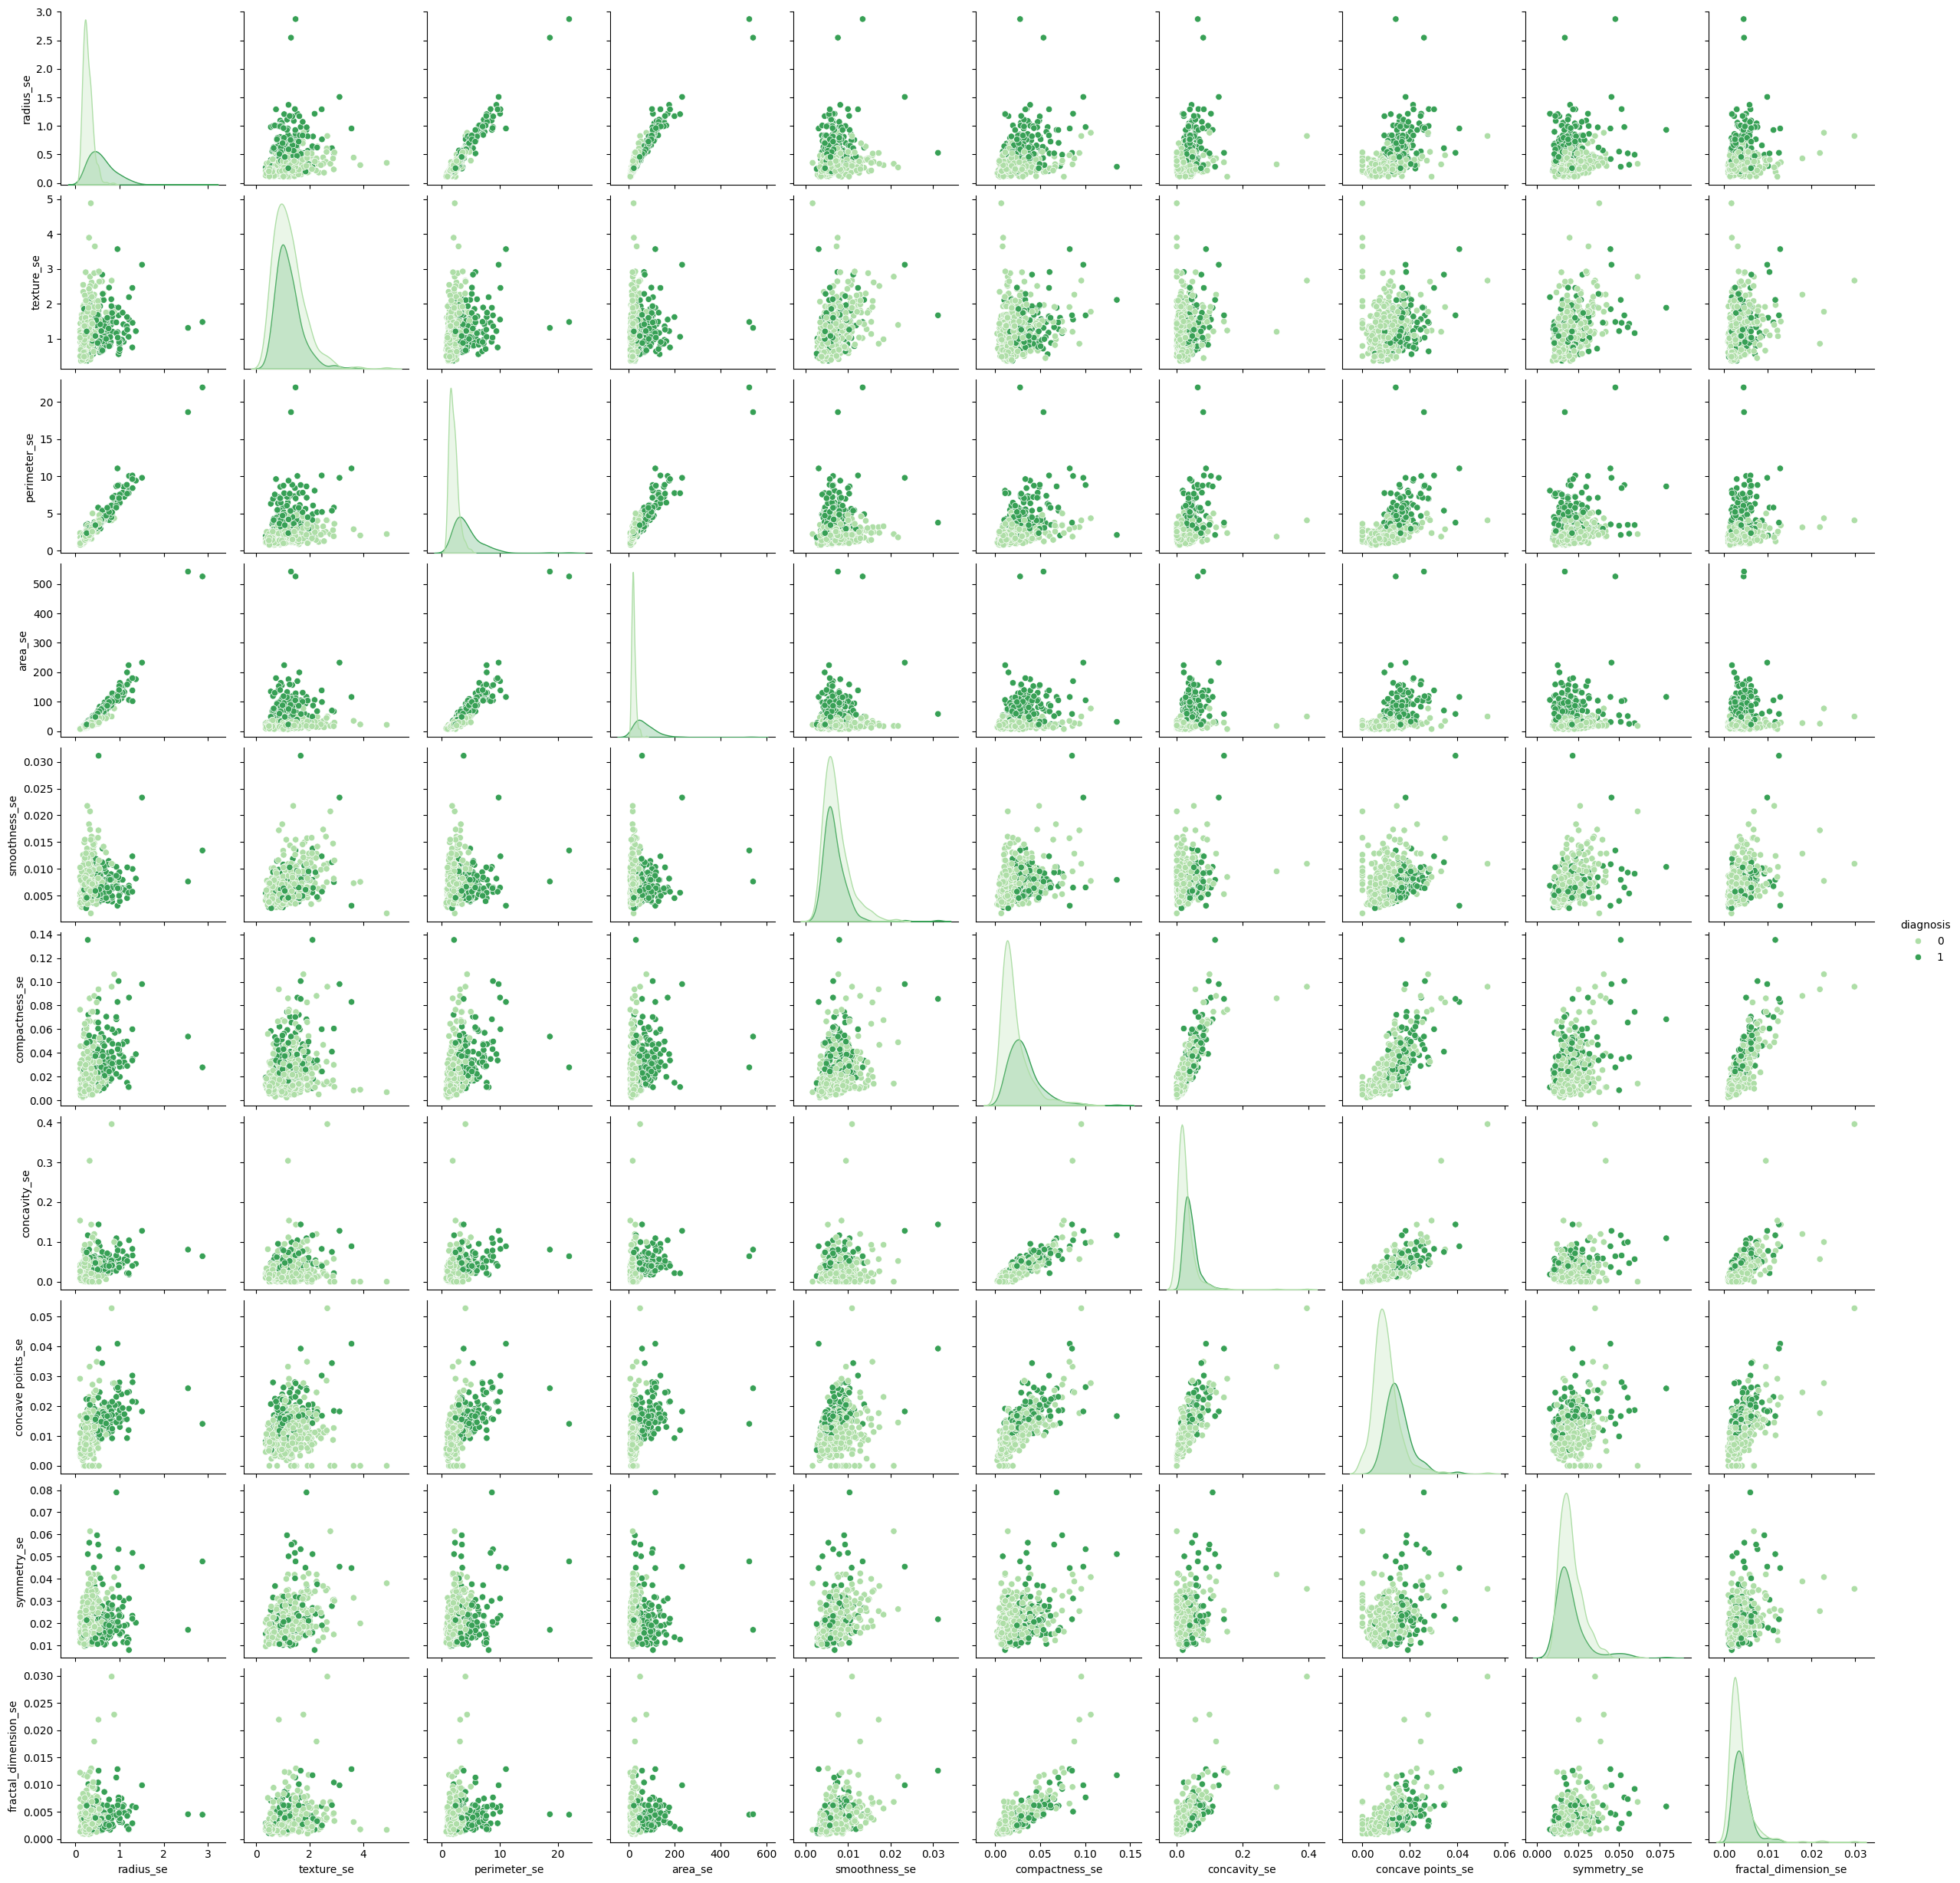

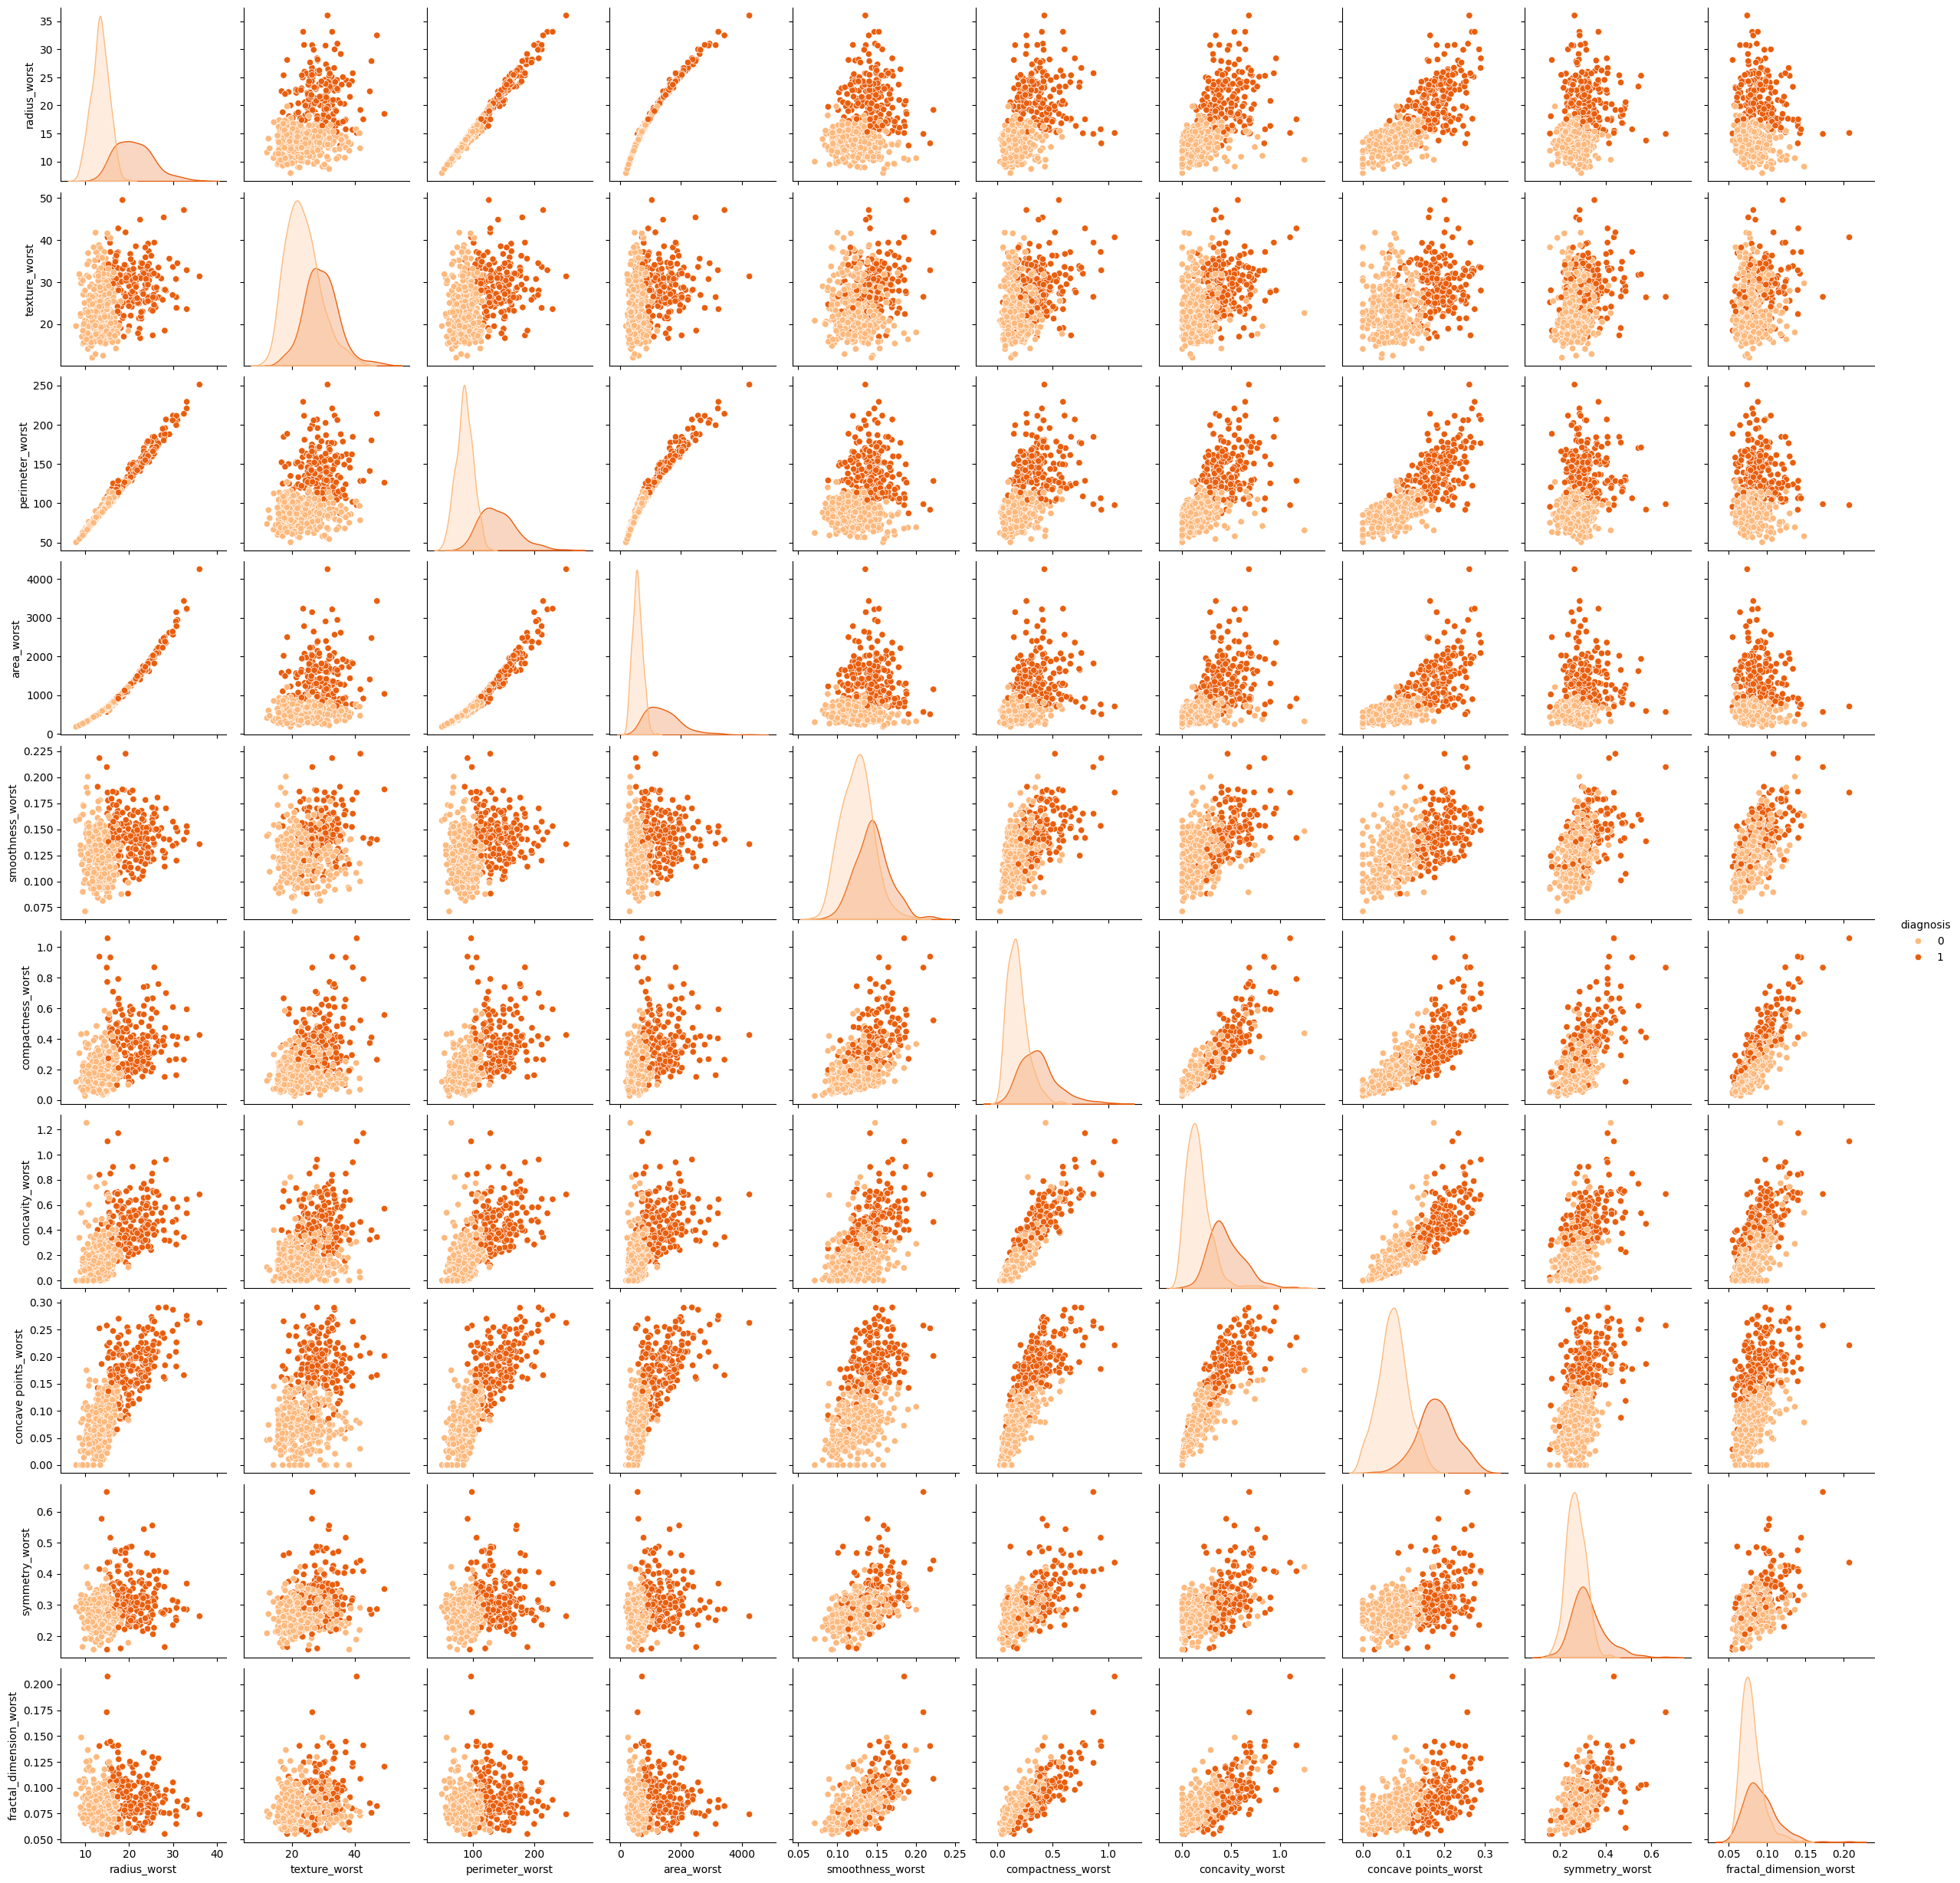

In [5]:
# Plot the correlation between each category and the diagnosis
sns.pairplot(
    data[features_mean.append(pd.Index(["diagnosis"]))],
    hue="diagnosis",
    palette="Blues",
)
sns.pairplot(
    data[features_se.append(pd.Index(["diagnosis"]))],
    hue="diagnosis",
    palette="Greens",
)
sns.pairplot(
    data[features_worst.append(pd.Index(["diagnosis"]))],
    hue="diagnosis",
    palette="Oranges",
)

### Data Splitting


In [6]:
# Split the data into training and testing sets (80% training, 20% testing)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### General Configuration


In [7]:
# Set up k-fold cross-validation
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "roc_auc": make_scorer(roc_auc_score),
}

### Support Vector Machine


In [8]:
# Define the hyperparameter grid
parameters = {
    "C": [0.01, 0.1, 1.0, 10.0, 100.0],  # regularization parameter
    "kernel": ["linear", "poly", "sigmoid", "rbf"],  # kernel type
    "gamma": [0.001, 0.01, 0.1, 1.0, 10.0, "auto", "scale"],  # kernel coefficient
}

# Create support vector classifier
svm_model = SVC(random_state=42)

# Perform grid search
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=parameters,
    cv=k_fold,
    scoring=scoring,
    refit="f1",
    return_train_score=True,
    n_jobs=-1,
)
grid_search.fit(X_train, y_train)

# Best parameters from grid search
best_params = grid_search.best_params_

# Best model from grid search
best_svm_model = grid_search.best_estimator_

/Users/mashina/miniconda3/envs/su/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/su/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/su/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mashina/miniconda3/envs/su/lib/python3.11/site-pack

### Model Evaluation


In [9]:
# Evaluate the model on the test set
y_pred = best_svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

### Model Comparison


In [10]:
# Print the information about the grid search
print("Grid Search Results:")
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_f1"], cv_results["params"]):
    print(f"- Parameters: {params}\n  ---> Mean F1 Score: {mean_score}")

print("\nBest Grid Search Results:")
print(f"Parameters: {best_params}")
print(f"---> Accuracy: {accuracy}")
print(f"---> Precision: {precision}")
print(f"---> Recall: {recall}")
print(f"---> F1 Score: {f1}")
print(f"---> ROC AUC Score: {roc_auc}")

Grid Search Results:
- Parameters: {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}
  ---> Mean F1 Score: 0.9473076923076924
- Parameters: {'C': 0.01, 'gamma': 0.001, 'kernel': 'poly'}
  ---> Mean F1 Score: 0.0
- Parameters: {'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}
  ---> Mean F1 Score: 0.0
- Parameters: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
  ---> Mean F1 Score: 0.0
- Parameters: {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}
  ---> Mean F1 Score: 0.9473076923076924
- Parameters: {'C': 0.01, 'gamma': 0.01, 'kernel': 'poly'}
  ---> Mean F1 Score: 0.02319327731092437
- Parameters: {'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}
  ---> Mean F1 Score: 0.011764705882352943
- Parameters: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
  ---> Mean F1 Score: 0.0
- Parameters: {'C': 0.01, 'gamma': 0.1, 'kernel': 'linear'}
  ---> Mean F1 Score: 0.9473076923076924
- Parameters: {'C': 0.01, 'gamma': 0.1, 'kernel': 'poly'}
  ---> Mean F1 Score: 0.7852875843112509
- Parameters: {'C': 0.01

### Diagnostic Plots


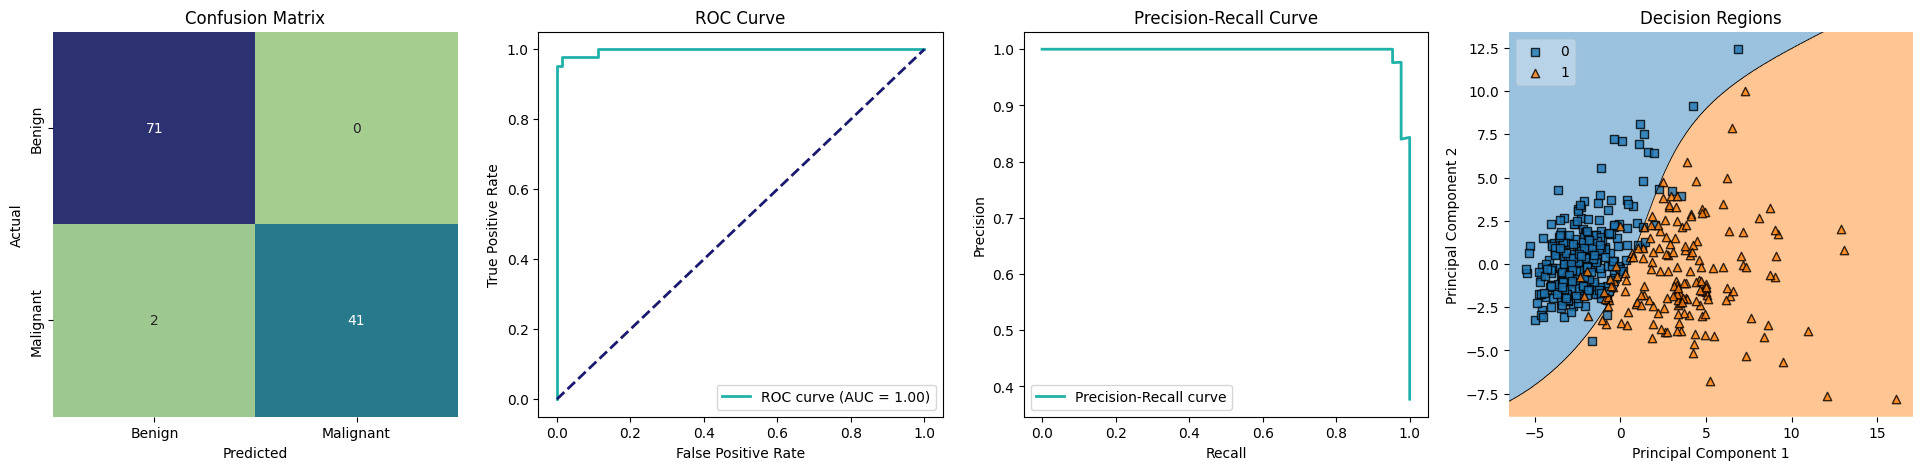

In [11]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, ax):
    # Calculate the confusion matrix
    matrix = confusion_matrix(y_true, y_pred)

    # Plot the heatmap of the confusion matrix
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="crest",
        cbar=False,
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax,
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(f"Confusion Matrix")


# Function to plot ROC curve
def plot_roc_curve(y_true, y_scores, ax):
    # Calculate the false positive rate and true positive rate
    false_positive_rate, true_positive_rage, _ = roc_curve(y_true, y_scores)
    # Calculate the area under the curve
    roc_auc = auc(false_positive_rate, true_positive_rage)

    # Plot the ROC curve and the diagonal line
    ax.plot(
        false_positive_rate,
        true_positive_rage,
        color="lightseagreen",
        lw=2,
        label=f"ROC curve (AUC = {roc_auc:.2f})",
    )
    ax.plot([0, 1], [0, 1], color="midnightblue", lw=2, linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve")
    ax.legend(loc="lower right")


# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_scores, ax):
    # Calculate the precision and recall
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    # Plot the Precision-Recall curve
    ax.plot(
        recall, precision, color="lightseagreen", lw=2, label="Precision-Recall curve"
    )
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision-Recall Curve")
    ax.legend(loc="lower left")


# Function to plot the decision regions
def plot_decision_regions(X, y, parameters, ax):
    from mlxtend.plotting import plot_decision_regions

    # Reduce the feature space to 2 dimensions using PCA
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X)

    # Fit the classifier using the reduced feature space
    model = SVC(**parameters)
    model.fit(X_train_pca, y)

    # Plot the decision regions
    plot_decision_regions(X_train_pca, y.to_numpy(), clf=model, legend=2, ax=ax)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_title("Decision Regions")


# Define class names
class_names = ["Benign", "Malignant"]

_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 5))

# Use the best model to predict the test set
y_scores = best_svm_model.decision_function(X_test)
y_pred = best_svm_model.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names, ax1)

# Plot ROC curve
plot_roc_curve(y_test, y_scores, ax2)

# Plot Precision-Recall curve
plot_precision_recall_curve(y_test, y_scores, ax3)

# Plot decision regions
plot_decision_regions(X_train, y_train, best_params, ax4)

### Data Retrieval & Data Preprocessing & Data Analyzing & Data Splitting & General Configuration


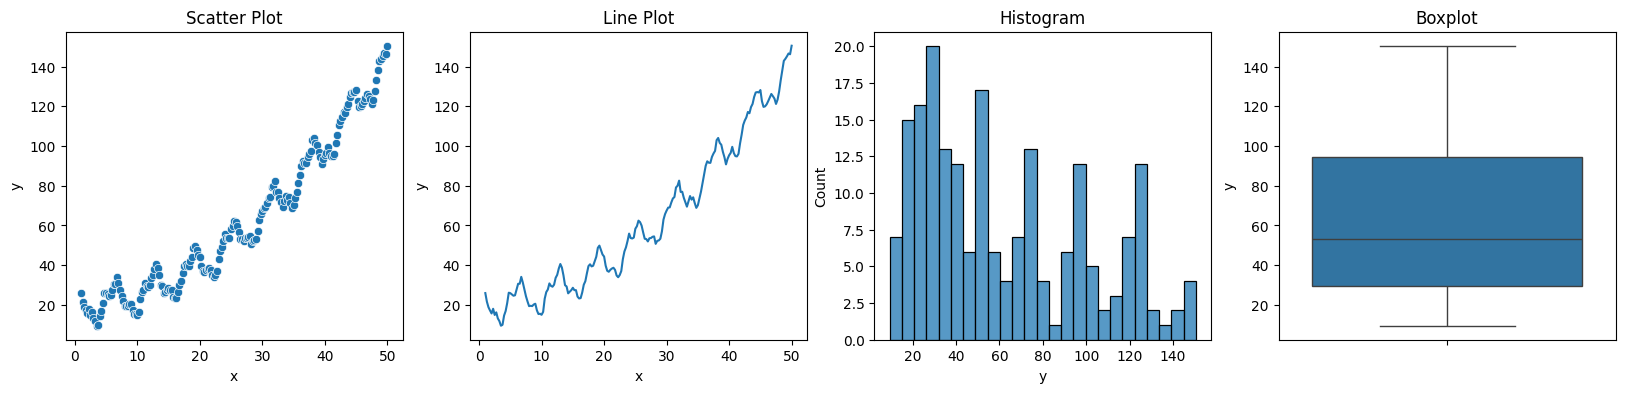

x           y
0     1.00   25.882522
1     1.25   21.573761
2     1.50   18.780320
3     1.75   17.122230
4     2.00   15.616773
..     ...         ...
192  49.00  143.968542
193  49.25  145.224493
194  49.50  146.653436
195  49.75  146.250501
196  50.00  150.564864

[197 rows x 2 columns]

In [12]:
# Read the data from the FRI Ucilnica
data = pd.read_csv("./data/data-fri.csv")

# Drop the Unnamed: 0 column
data.drop(["Unnamed: 0"], axis=1, inplace=True)

_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))

# Plot the scatter plot
sns.scatterplot(x="x", y="y", data=data, ax=ax1)
ax1.set_title("Scatter Plot")

# Plot the line plot
sns.lineplot(x="x", y="y", data=data, ax=ax2)
ax2.set_title("Line Plot")

# Plot the histogram
sns.histplot(data["y"], bins=25, ax=ax3)
ax3.set_title("Histogram")

# Plot the boxplot
sns.boxplot(data["y"], ax=ax4)
ax4.set_title("Boxplot")

plt.show()

# Split the data into training and testing sets (80% training, 20% testing)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Order the data by the x column
data_train = pd.concat([X_train, y_train], axis=1).sort_values(by=["x"])
data_test = pd.concat([X_test, y_test], axis=1).sort_values(by=["x"])
X_train, y_train = data_train.iloc[:, :-1], data_train.iloc[:, -1]
X_test, y_test = data_test.iloc[:, :-1], data_test.iloc[:, -1]

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define epsilon to avoid division by zero
epsilon = 1e-10

data

### Kernel Regression

Kernels are available at: https://scikit-learn.org/stable/modules/metrics.html


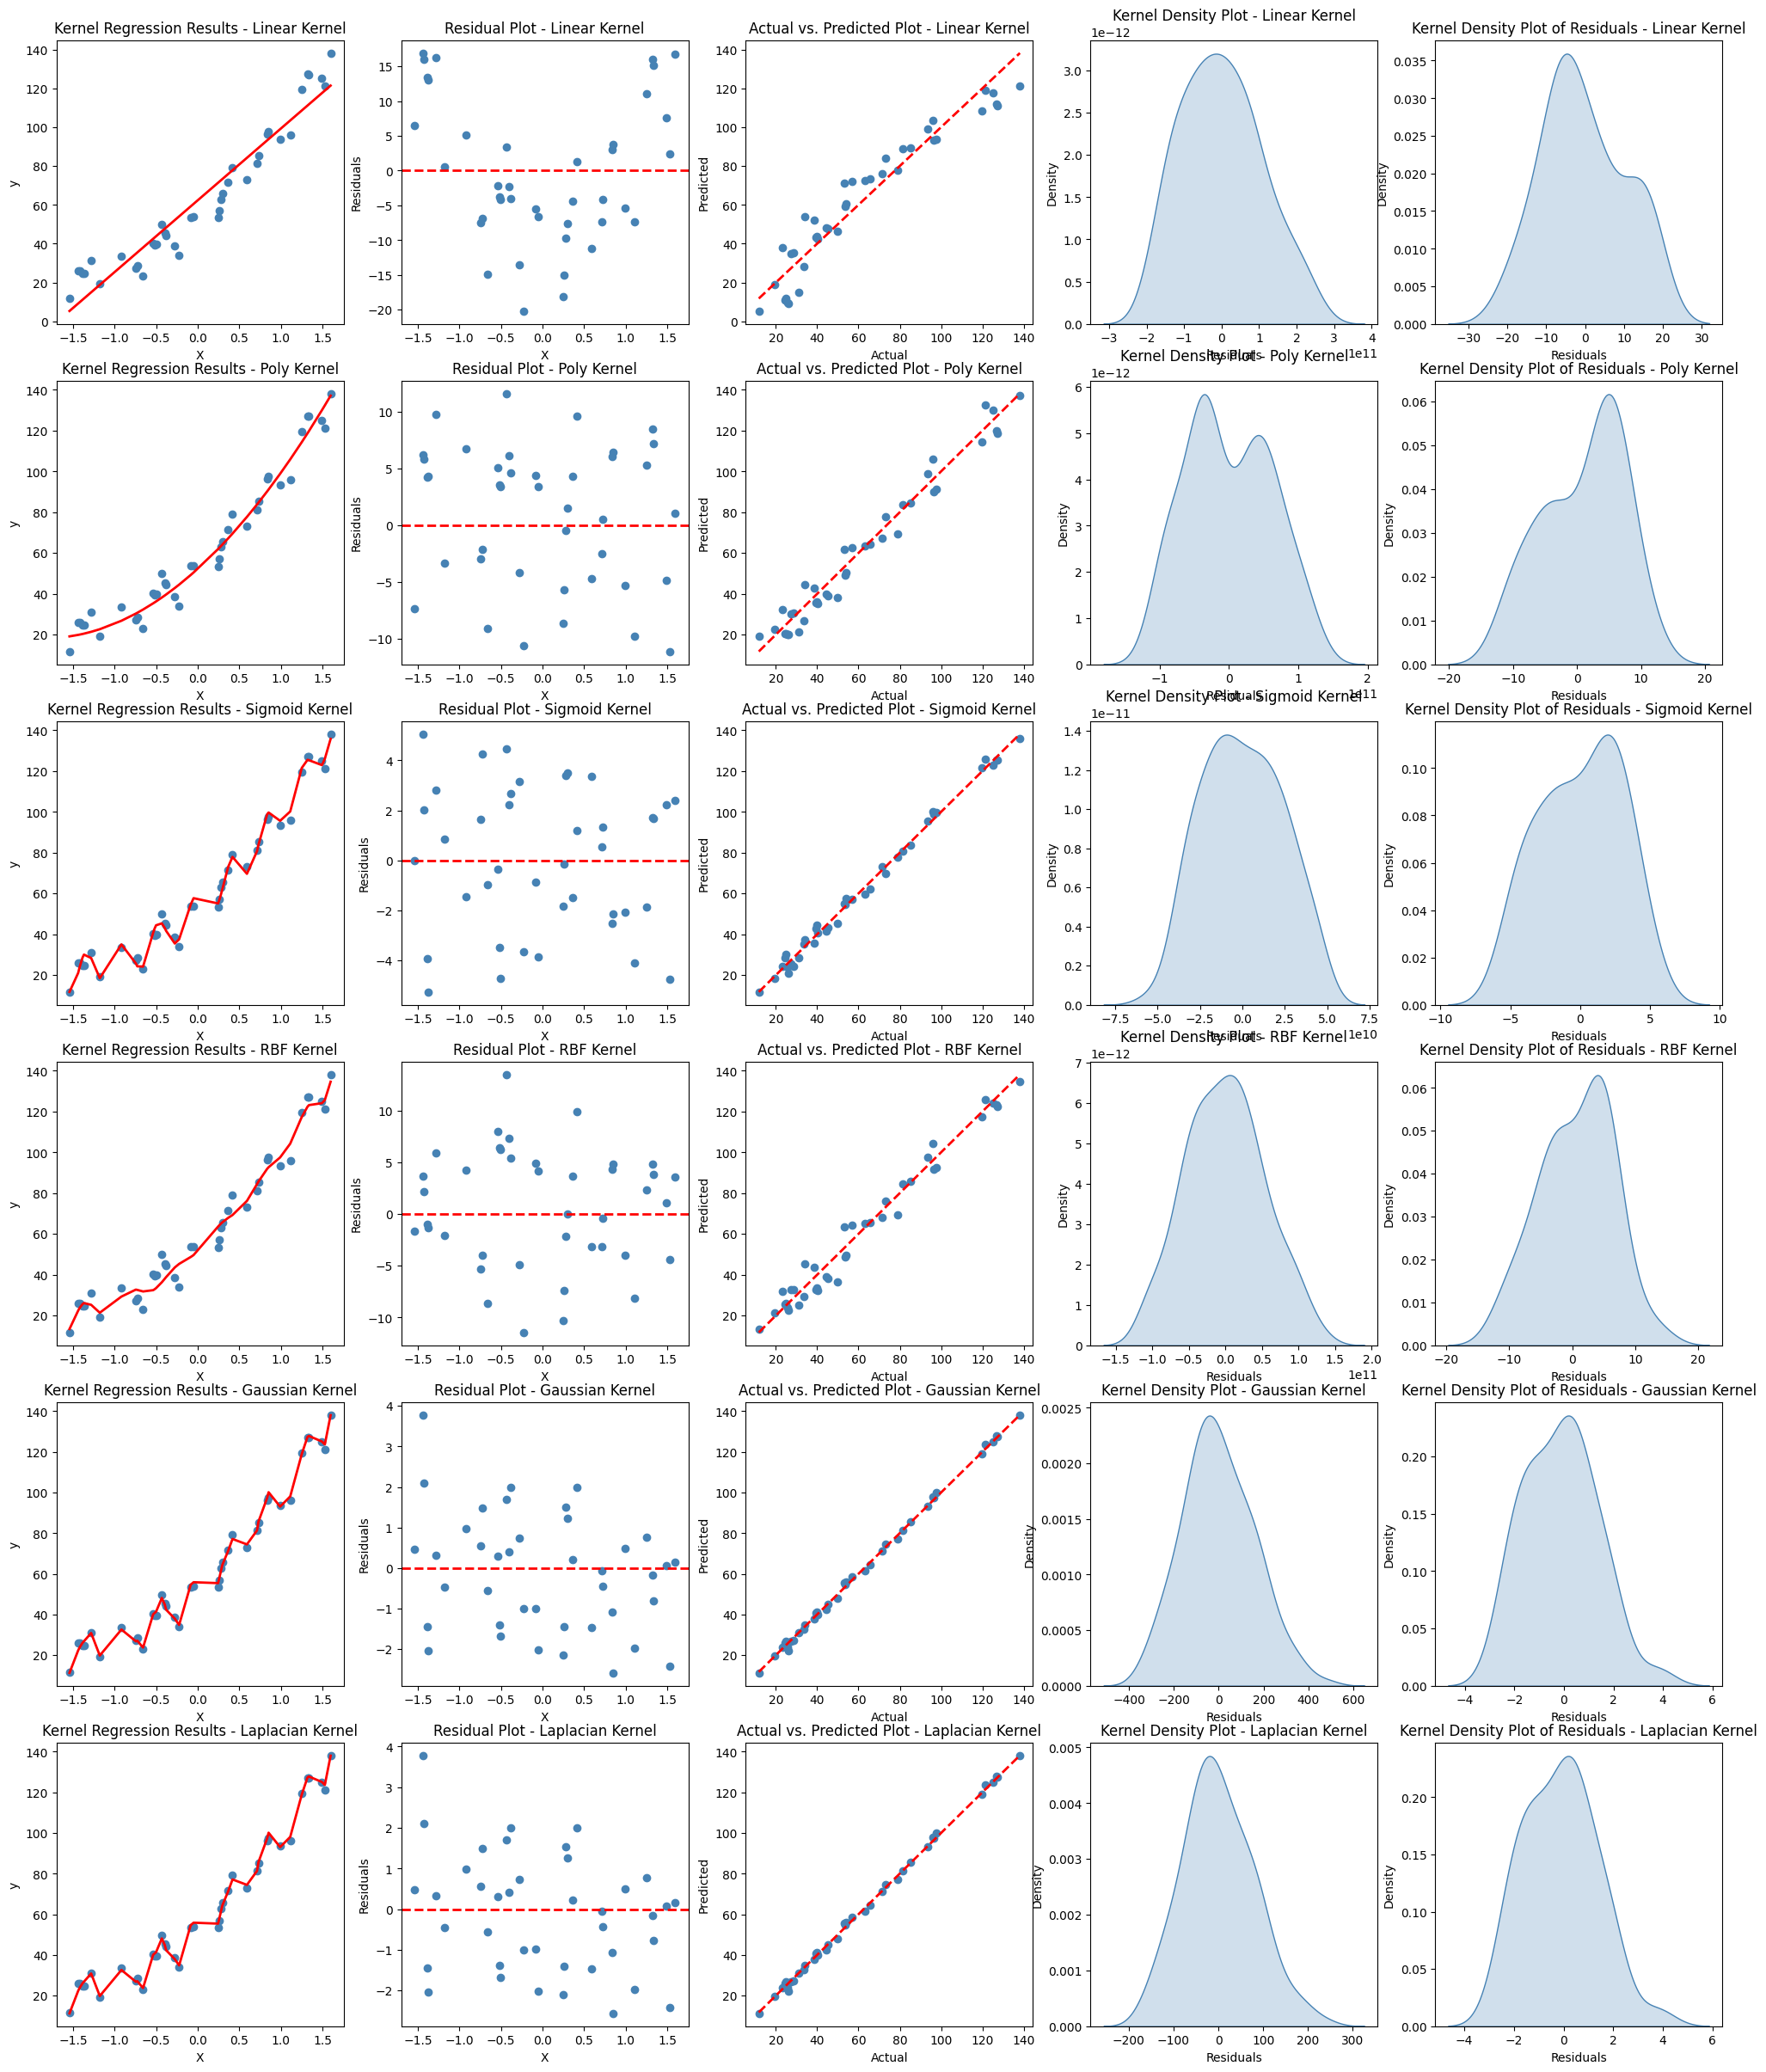

In [13]:
# Linear kernel
def linear_kernel(x, y):
    x = np.insert(x, 0, 1.0)
    y = np.insert(y, 0, 1.0)
    return np.dot(x, y)


# Polynomial Kernel
def polynomial_kernel(x, y, degree=2.0, gamma=1.0, coef0=1.0):
    return (gamma * np.dot(x, y) + coef0) ** degree


# Sigmoid Kernel
def sigmoid_kernel(x, y, gamma=1.0, coef0=1.0):
    return np.tanh(gamma * np.dot(x, y) + coef0)


# RBF Kernel (uses euclidean distance)
def rbf_kernel(x, y, gamma=1.0):
    return np.exp(-gamma * np.linalg.norm(x - y) ** 2)


# Gaussian Kernel (special case of RBF kernel with gamma = 1/2*sigma^2)
def gaussian_kernel(x, y):
    return np.exp(-0.5 * np.linalg.norm(x - y))


# Laplacian Kernel (special case of RBF kernel with manhattan distance)
def laplacian_kernel(x, y, gamma=1.0):
    return np.exp(-gamma * np.linalg.norm(x - y, ord=1))


# Chi-squared Kernel (this is basically additive chi-squared kernel)
def chi2_kernel(x, y):
    return np.exp(-np.sum((x - y) ** 2 / (x + y + epsilon)))


# Cosine Similarity Kernel
def cosine_kernel(x, y):
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    return np.dot(x, y) / (norm_x * norm_y + epsilon)


# Compute the kernel matrix
def compute_kernel_matrix(X, kernel):
    # Get the number of data points and initialize the kernel matrix
    n = len(X)
    K = np.zeros((n, n))

    # Loop through the data points and compute the kernel matrix
    for index_1 in range(n):
        for index_2 in range(n):
            K[index_1, index_2] = kernel(X[index_1, :], X[index_2, :])

    return K


# Compute the alpha values (alpha = K^-1 * y)
def compute_alpha(K, y):
    K = np.linalg.inv(K + 1e-10 * np.eye(K.shape[0]))
    return np.dot(K, y)


# Compute predictions for the test set
def predict(X_train, _, X_test, kernel, alpha):
    # Get the number of data points and initialize the predictions
    n_train = len(X_train)
    n_test = len(X_test)
    y_pred = np.zeros(n_test)

    # Loop through the test points and compute the predictions
    for index_1 in range(n_test):
        k = np.zeros(n_train)
        for index_2 in range(n_train):
            k[index_2] = kernel(X_train[index_2, :], X_test[index_1, :])
        y_pred[index_1] = np.dot(k, alpha)

    return y_pred


# Define kernels
kernels = [
    ("Linear Kernel", linear_kernel),
    ("Poly Kernel", polynomial_kernel),
    ("Sigmoid Kernel", sigmoid_kernel),
    ("RBF Kernel", rbf_kernel),
    ("Gaussian Kernel", gaussian_kernel),
    ("Laplacian Kernel", laplacian_kernel),
    # ("Chi-squared Kernel", chi2_kernel),
    # ("Cosine Similarity Kernel", cosine_kernel),
]

# Define error metrics (kernel name, mse, mae, r2)
error_metrics = []

_, axes = plt.subplots(len(kernels), 5, figsize=(25, 30))

# Loop through the kernels
for index, (kernel_name, kernel_function) in enumerate(kernels):
    # Compute the kernel matrix
    K_train = compute_kernel_matrix(X_train, kernel_function)

    # Compute alpha = K^-1 y
    alpha = compute_alpha(K_train, y_train)

    # Compute predictions for the test points
    y_pred = predict(X_train, y_train, X_test, kernel_function, alpha)

    # Compute the residuals
    residuals = y_test - y_pred

    # Calculate the error metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    error_metrics.append((kernel_name, mse, mae, r2))

    # Plot the kernel predictions
    axes[index][0].scatter(X_test, y_test, color="steelblue")
    axes[index][0].plot(X_test, y_pred, color="red", linewidth=2)
    axes[index][0].set_title(f"Kernel Regression Results - {kernel_name}")
    axes[index][0].set_xlabel("X")
    axes[index][0].set_ylabel("y")

    # Plot the residuals
    axes[index][1].scatter(X_test, residuals, color="steelblue")
    axes[index][1].axhline(y=0, color="red", linestyle="--", linewidth=2)
    axes[index][1].set_title(f"Residual Plot - {kernel_name}")
    axes[index][1].set_xlabel("X")
    axes[index][1].set_ylabel("Residuals")

    # Plot the actual vs. predicted plot
    axes[index][2].scatter(y_test, y_pred, color="steelblue")
    axes[index][2].plot(
        [min(y_test), max(y_test)],
        [min(y_test), max(y_test)],
        linestyle="--",
        color="red",
        linewidth=2,
    )
    axes[index][2].set_title(f"Actual vs. Predicted Plot - {kernel_name}")
    axes[index][2].set_xlabel("Actual")
    axes[index][2].set_ylabel("Predicted")

    # Plot the kernel density plot
    sns.kdeplot(alpha, color="steelblue", fill=True, ax=axes[index][3])
    axes[index][3].set_title(f"Kernel Density Plot - {kernel_name}")
    axes[index][3].set_xlabel("Residuals")
    axes[index][3].set_ylabel("Density")

    # Plot the kernel density plot of the residuals
    sns.kdeplot(residuals, color="steelblue", fill=True, ax=axes[index][4])
    axes[index][4].set_title(f"Kernel Density Plot of Residuals - {kernel_name}")
    axes[index][4].set_xlabel("Residuals")
    axes[index][4].set_ylabel("Density")

plt.show()

### Model Comparison


In [14]:
# Print the error metrics
for kernel_name, mse, mae, r2 in error_metrics:
    print(f"[{kernel_name}] Mean Absolute Error: {mae}")
    print(f"[{kernel_name}] Mean Squared Error: {mse}")
    print(f"[{kernel_name}] R2 Score: {r2}")
    print()

[Linear Kernel] Mean Absolute Error: 8.757791687546415
[Linear Kernel] Mean Squared Error: 106.81735202499381
[Linear Kernel] R2 Score: 0.9149326906506672

[Poly Kernel] Mean Absolute Error: 5.5733478790579385
[Poly Kernel] Mean Squared Error: 39.333139439069626
[Poly Kernel] R2 Score: 0.9686758351811523

[Sigmoid Kernel] Mean Absolute Error: 2.5046012002022615
[Sigmoid Kernel] Mean Squared Error: 8.26754942544517
[Sigmoid Kernel] R2 Score: 0.9934158807421973

[RBF Kernel] Mean Absolute Error: 4.849426043103269
[RBF Kernel] Mean Squared Error: 32.6243003554574
[RBF Kernel] R2 Score: 0.9740186271422093

[Gaussian Kernel] Mean Absolute Error: 1.1857367813215833
[Gaussian Kernel] Mean Squared Error: 2.0935236837131534
[Gaussian Kernel] R2 Score: 0.9983327575206048

[Laplacian Kernel] Mean Absolute Error: 1.1834279570716886
[Laplacian Kernel] Mean Squared Error: 2.084898455498633
[Laplacian Kernel] R2 Score: 0.9983396264884534



### Conclusion

In this assignment, we have learned about support vector machine and kernel methods.

Using the Breast Cancer Wisconsin dataset, we performed the support vector machine classification, for predicting if the tumor is malignant or benign. We have tried different regularization parameters, kernel types and kernel parameters. Using the `GridSearchCV` function, we have found the best parameters for the model. The parameters for the best model are: `C = 10.0`, `kernel = 'rbf'` and `gamma = 0.01`. Based on these parameters we have trained the model and evaluated it on the test set. The accuracy results are:

```json
Accuracy: 0.9824561403508771
Precision: 1.0
Recall: 0.9534883720930233
F1 Score: 0.9761904761904763
ROC AUC Score: 0.9767441860465116
```

Plotting the final results we got using SVM with RBF kernel, we can see that the model is performing very well. The model is able to predict all the benign tumors correctly, but it is not able to predict all the malignant tumors correctly. The model is predicting some of the malignant tumors as benign. This is not a big problem, since it is better to predict a malignant tumor as benign, than the other way around. Overall the model is performing very well.

We noticed that the dataset is a bit unbalanced, since there are more benign tumors than malignant ones. We tried to balance the dataset or at least its impact on the model. We have also tried the more balanced version of cross validation, `StratifiedKFold`. The results were not much different. We have also noticed that the data features can be split into three groups, which are correlated. The groups / categories are: mean, se and worst. We have tried to use only one of the groups, but the results were worse than using all the features.

In the second part of the assignment we have implemented the kernel regression on the data from Ucilnica. We have implemented 8 different kernels and compared them. The best kernel was the `RBF` kernel variant `Laplacian Kernel`. Sadly we could not compare the Chi2-Squared kernel, and Cosine kernel, since there came to some overflow errors while computing the kernel matrix. The results of the kernels are:

```json
[Linear Kernel] Mean Absolute Error: 8.757791687546415
[Linear Kernel] Mean Squared Error: 106.81735202499381
[Linear Kernel] R2 Score: 0.9149326906506672

[Poly Kernel] Mean Absolute Error: 5.5733478790579385
[Poly Kernel] Mean Squared Error: 39.333139439069626
[Poly Kernel] R2 Score: 0.9686758351811523

[Sigmoid Kernel] Mean Absolute Error: 2.5046012002022615
[Sigmoid Kernel] Mean Squared Error: 8.26754942544517
[Sigmoid Kernel] R2 Score: 0.9934158807421973

[RBF Kernel] Mean Absolute Error: 4.849426043103269
[RBF Kernel] Mean Squared Error: 32.6243003554574
[RBF Kernel] R2 Score: 0.9740186271422093

[Gaussian Kernel] Mean Absolute Error: 1.1857367813215833
[Gaussian Kernel] Mean Squared Error: 2.0935236837131534
[Gaussian Kernel] R2 Score: 0.9983327575206048

[Laplacian Kernel] Mean Absolute Error: 1.1834279570716886
[Laplacian Kernel] Mean Squared Error: 2.084898455498633
[Laplacian Kernel] R2 Score: 0.9983396264884534
```

The results are also plotted. From the graphs we can see that all kernels except `RBF` based kernels don't work as well as the `RBF` based kernels. The `RBF` based kernels are able to predict the data very well. The `Laplacian Kernel` is the best kernel, since it is able to predict the data very well, and it is also very smooth. The second best kernel is `Gaussian Kernel` which also works pretty good.
